In [1]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

In [2]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='synthetic',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=5,
    hidden_graphs=16,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=32,
    max_step=2,
    normalize=False,
)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=13)
it = 0
accs = list()

In [5]:
# THE MODEL
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device

        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.adj_hidden_tree = None
        self.adj_hidden_tree_norm = None
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.hidden_dim = hidden_dim
        self.features_hidden_tree = None
        self.input_dim = input_dim
        self.penultimate_dim = penultimate_dim

        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator, y=None):            
        self.fc = torch.nn.Linear(self.input_dim, self.hidden_dim)
        self.bn = nn.BatchNorm1d(self.hidden_graphs*self.max_step)
        self.fc1 = torch.nn.Linear(self.hidden_graphs*self.max_step, self.penultimate_dim)
        self.fc2 = torch.nn.Linear(self.penultimate_dim, n_classes)
        unique, counts = torch.unique(graph_indicator, return_counts=True)
        n_graphs = unique.size(0)
        n_nodes = features.size(0)

        if self.normalize:
            norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
        
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        x = self.sigmoid(self.fc(features))
        z = self.features_hidden
        zx = torch.einsum("abc,dc->abd", (z, x))
        
        out = list()
        for i in range(self.max_step):
            if i == 0:
                eye = torch.eye(self.size_hidden_graphs, device=self.device)
                eye = eye.repeat(self.hidden_graphs, 1, 1)              
                o = torch.einsum("abc,acd->abd", (eye, z))
                t = torch.einsum("abc,dc->abd", (o, x))
            else:
                x = torch.spmm(adj, x)
                z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                t = torch.einsum("abc,dc->abd", (z, x))
            t = self.dropout(t)
            t = torch.mul(zx, t)
            t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
            t = torch.sum(t, dim=1)
            t = torch.transpose(t, 0, 1)
            if self.normalize:
                t /= norm
            out.append(t)
            
        out = torch.cat(out, dim=1)
        out = self.bn(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists

In [6]:
for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()

        for i in range(n_val_batches):
            output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
            val_loss.update(loss.item(), output.size(0))
            val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

        scheduler.step()
        
        # Print results
        print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
            "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
            "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))
        
        # Remember best accuracy and save checkpoint
        is_best = val_acc.avg >= best_acc
        best_acc = max(val_acc.avg, best_acc)
        if is_best:
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, 'model_best.pth.tar')

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()
    
print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))

Cross-val iter: 01 epoch: 001 train_loss= 0.70925 train_acc= 0.47500 val_loss= 0.72195 val_acc= 0.20000 time= 0.02535
Cross-val iter: 01 epoch: 002 train_loss= 0.70935 train_acc= 0.50000 val_loss= 0.66838 val_acc= 0.80000 time= 0.00867
Cross-val iter: 01 epoch: 003 train_loss= 0.71596 train_acc= 0.50000 val_loss= 0.65853 val_acc= 0.80000 time= 0.01288
Cross-val iter: 01 epoch: 004 train_loss= 0.68548 train_acc= 0.52500 val_loss= 0.74794 val_acc= 0.20000 time= 0.00966
Cross-val iter: 01 epoch: 005 train_loss= 0.67212 train_acc= 0.62500 val_loss= 0.68397 val_acc= 0.80000 time= 0.01719
Optimization finished!
Loading checkpoint!
test_loss= 0.73602 test_acc= 0.40000

Cross-val iter: 02 epoch: 001 train_loss= 0.67065 train_acc= 0.50000 val_loss= 0.69299 val_acc= 0.60000 time= 0.00970
Cross-val iter: 02 epoch: 002 train_loss= 0.69306 train_acc= 0.47500 val_loss= 0.69267 val_acc= 0.60000 time= 0.01372
Cross-val iter: 02 epoch: 003 train_loss= 0.68638 train_acc= 0.50000 val_loss= 0.69938 val_ac

In [7]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
    print(f"Hidden Graph {i}:")
    for node, neighbors in adj_list.items():
        print(f"  Node {node}: {neighbors}")

Hidden Graph 0:
  Node 0: [2, 3]
  Node 1: [2, 3]
  Node 2: [0, 1, 3]
  Node 3: [0, 1, 2, 4]
  Node 4: [3]
Hidden Graph 1:
  Node 0: [2, 4]
  Node 1: [4]
  Node 2: [0]
  Node 3: []
  Node 4: [0, 1]
Hidden Graph 2:
  Node 0: [3, 4]
  Node 1: [2, 3]
  Node 2: [1, 4]
  Node 3: [0, 1, 4]
  Node 4: [0, 2, 3]
Hidden Graph 3:
  Node 0: [1, 3]
  Node 1: [0, 2]
  Node 2: [1]
  Node 3: [0]
  Node 4: []
Hidden Graph 4:
  Node 0: [1, 3]
  Node 1: [0, 2, 3]
  Node 2: [1, 3]
  Node 3: [0, 1, 2, 4]
  Node 4: [3]
Hidden Graph 5:
  Node 0: [1, 3]
  Node 1: [0, 3, 4]
  Node 2: [4]
  Node 3: [0, 1]
  Node 4: [1, 2]
Hidden Graph 6:
  Node 0: [1, 2]
  Node 1: [0, 2, 3, 4]
  Node 2: [0, 1]
  Node 3: [1, 4]
  Node 4: [1, 3]
Hidden Graph 7:
  Node 0: [1, 2, 3]
  Node 1: [0, 2]
  Node 2: [0, 1]
  Node 3: [0, 4]
  Node 4: [3]
Hidden Graph 8:
  Node 0: []
  Node 1: [3]
  Node 2: [4]
  Node 3: [1]
  Node 4: [2]
Hidden Graph 9:
  Node 0: [2, 3]
  Node 1: [4]
  Node 2: [0, 4]
  Node 3: [0]
  Node 4: [1, 2]
Hidden G

### MAJOR DIFFERENCES START HERE

In [8]:
import scipy.sparse as sp
import networkx as nx
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# able to get the feature and adj list of each hidden graph 
# cuz that's what feeds into the vgae

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
     # Create a NetworkX graph from the adjacency list
    graph = nx.from_dict_of_lists(adj_list)
    
    # Convert the NetworkX graph into a sparse adjacency matrix
    adj_sparse = nx.adjacency_matrix(graph)
    
    # Print the sparse matrix (for debugging or visualization)
    print(f"Graph {i + 1}:")
    print("Adjacency List:", adj_list)
    print("Sparse Matrix:\n", adj_sparse.todense())  # Use `todense()` for visualization

    # Optionally: Create dummy features (identity matrix)
    num_nodes = adj_sparse.shape[0]
    features = sp.identity(num_nodes).tolil()
    print("Node Features:\n", features.todense())

Graph 1:
Adjacency List: {0: [2, 3], 1: [2, 3], 2: [0, 1, 3], 3: [0, 1, 2, 4], 4: [3]}
Sparse Matrix:
 [[0 0 1 1 0]
 [0 0 1 1 0]
 [1 1 0 1 0]
 [1 1 1 0 1]
 [0 0 0 1 0]]
Node Features:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Graph 2:
Adjacency List: {0: [2, 4], 1: [4], 2: [0], 3: [], 4: [0, 1]}
Sparse Matrix:
 [[0 0 1 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Node Features:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Graph 3:
Adjacency List: {0: [3, 4], 1: [2, 3], 2: [1, 4], 3: [0, 1, 4], 4: [0, 2, 3]}
Sparse Matrix:
 [[0 0 0 1 1]
 [0 0 1 1 0]
 [0 1 0 0 1]
 [1 1 0 0 1]
 [1 0 1 1 0]]
Node Features:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Graph 4:
Adjacency List: {0: [1, 3], 1: [0, 2], 2: [1], 3: [0], 4: []}
Sparse Matrix:
 [[0 1 0 1 0]
 [1 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Node Features:
 [[1. 0. 0. 0. 0.]
 

### VAGE PART

In [9]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time

from input_data import load_data
from preprocessing import preprocess_graph
import vgae_model
from types import SimpleNamespace

vgae_args = SimpleNamespace(
    ### CONFIGS ###
    model = 'VGAE',
    input_dim = 5, 
    hidden1_dim = 32,
    hidden2_dim = 16,
    use_feature = True,
    num_epoch = 200,
    learning_rate = 0.01
)


In [10]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape
def mask_test_edges(adj):
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]

    num_edges = edges.shape[0]
    if num_edges < 10:
        print("Not enough edges for a split. Using all edges for training.")
        return edges, [], []  # Return all edges for training, no validation/test

    num_test = int(np.floor(num_edges / 10.))
    num_val = int(np.floor(num_edges / 20.))

    all_edge_idx = list(range(num_edges))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]

    test_edges = edges[test_edge_idx] if test_edge_idx else []
    val_edges = edges[val_edge_idx] if val_edge_idx else []
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    return train_edges, val_edges, test_edges


In [15]:
import os
import numpy as np
import scipy.sparse as sp
import networkx as nx
import torch  # Add this to check for tensors

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

# Get adjacency lists from model
# Create graph from the first hidden graph's adjacency list
graph = nx.from_dict_of_lists(adjacency_lists[0])

# Convert graph to adjacency matrix
adj = nx.adjacency_matrix(graph)

# Check if adj is a PyTorch tensor and convert it to scipy sparse matrix
if isinstance(adj, torch.Tensor):
    adj = adj.cpu().numpy()  # Convert tensor to numpy array
    adj = sp.coo_matrix(adj)  # Convert numpy array to sparse matrix

# Ensure adjacency matrix is sparse (in case it's not already)
if not sp.isspmatrix(adj):
    adj = sp.coo_matrix(adj)

# Generate feature matrix (identity matrix in sparse format)
num_nodes = adj.shape[0]
features = sp.identity(num_nodes).tolil()

# Store original adjacency matrix (without diagonal entries)
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

print("Original Adjacency Matrix (without diagonal):\n", adj_orig)

# Mask the edges (train/validation/test split)
train_edges, val_edges, test_edges = mask_test_edges(adj)

# Using the training adjacency matrix
adj_train = adj  # Assuming adj_train is returned or defined within mask_test_edges

# Ensure adj is in sparse format after edge masking


Original Adjacency Matrix (without diagonal):
   (0, 2)	1
  (0, 3)	1
  (1, 2)	1
  (1, 3)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (3, 4)	1
  (4, 3)	1
Not enough edges for a split. Using all edges for training.


In [16]:
# Some preprocessing
adj_norm = preprocess_graph(adj)


num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create Model
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)



adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
features = torch.sparse.FloatTensor(torch.LongTensor(features[0].T), 
                            torch.FloatTensor(features[1]), 
                            torch.Size(features[2]))

weight_mask = adj_label.to_dense().view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

# init model and optimizer
model = getattr(vgae_model,vgae_args.model)(adj_norm)
optimizer = Adam(model.parameters(), lr=vgae_args.learning_rate)



In [17]:

def get_scores(edges_pos, edges_neg, adj_rec):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    preds = []
    pos = []
    for e in edges_pos:
        # print(e)
        # print(adj_rec[e[0], e[1]])
        preds.append(sigmoid(adj_rec[e[0], e[1]].item()))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:

        preds_neg.append(sigmoid(adj_rec[e[0], e[1]].data))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

def get_acc(adj_rec, adj_label):
    labels_all = adj_label.to_dense().view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy

In [19]:
# Initialize VGAE model with the adjacency matrix
adj_dense = torch.tensor(adj.toarray(), dtype=torch.float32)  # Ensure it's a tensor

model = vgae_model.VGAE(adj_dense)  # Make sure to pass the adjacency matrix during initialization
print(features.shape)
# Training loop
for epoch in range(vgae_args.num_epoch):
    t = time.time()

    # Pass the features to the model
    A_pred = model(features)
    
    optimizer.zero_grad()
    
    # Compute loss
    loss = log_lik = norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight=weight_tensor)
    
    if vgae_args.model == 'VGAE':
        # KL divergence regularization
        kl_divergence = 0.5 / A_pred.size(0) * (1 + 2 * model.logstd - model.mean**2 - torch.exp(model.logstd)**2).sum(1).mean()
        loss -= kl_divergence

    # Backpropagate and optimize
    loss.backward()
    optimizer.step()

    # Compute train accuracy
    train_acc = get_acc(A_pred, adj_label)

    # Evaluate on validation set
    # val_roc, val_ap = get_scores(val_edges, val_edges_false, A_pred)
    
    # # Print training stats
    # print(f"Epoch: {epoch + 1:04d} train_loss={loss.item():.5f} train_acc={train_acc:.5f} "
    #       f"val_roc={val_roc:.5f} val_ap={val_ap:.5f} time={time.time() - t:.5f}")

# # Evaluate on test set after training
# test_roc, test_ap = get_scores(test_edges, test_edges_false, A_pred)
# print(f"End of training! test_roc={test_roc:.5f} test_ap={test_ap:.5f}")


torch.Size([5, 5])


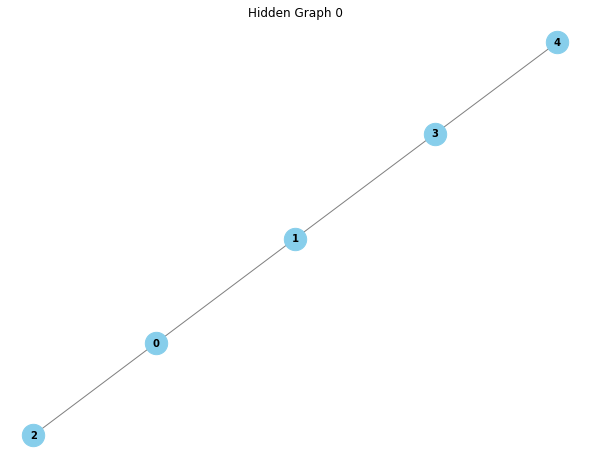

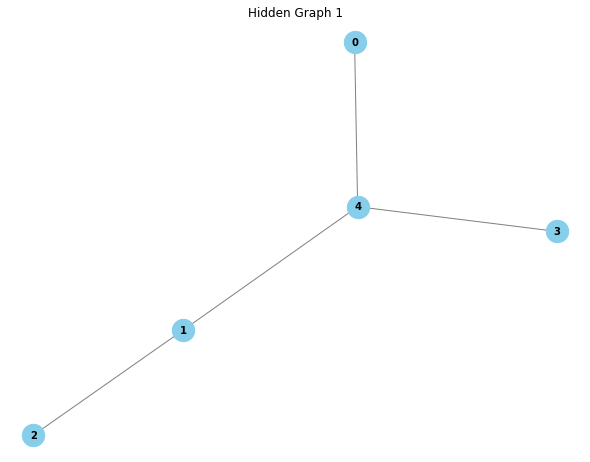

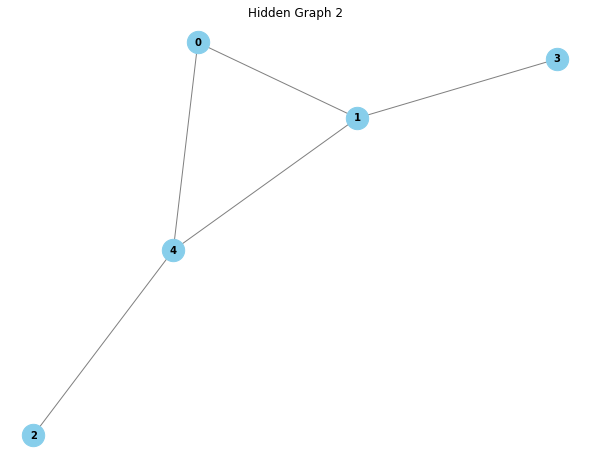

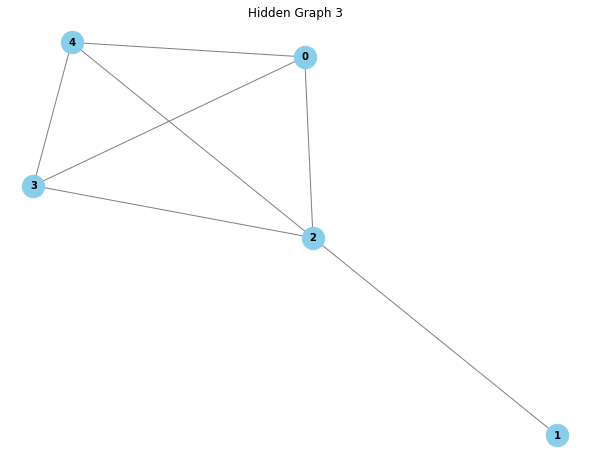

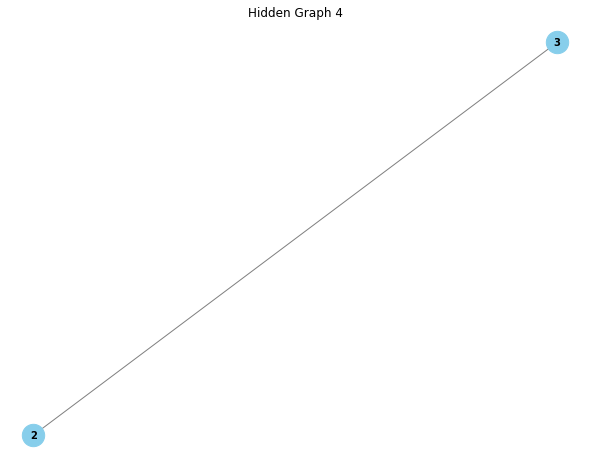

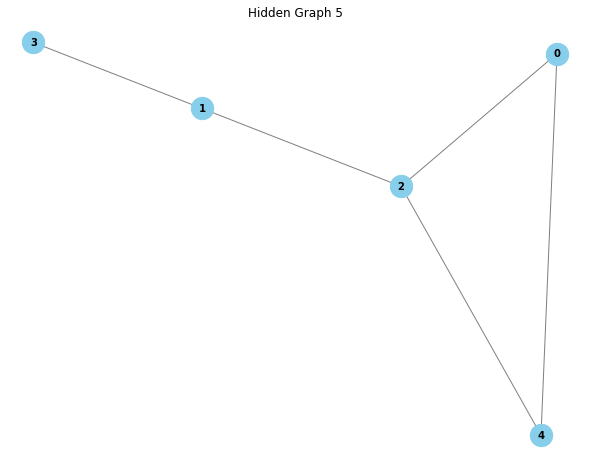

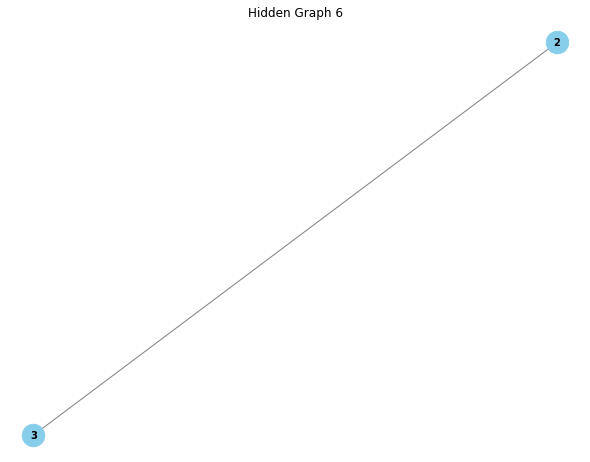

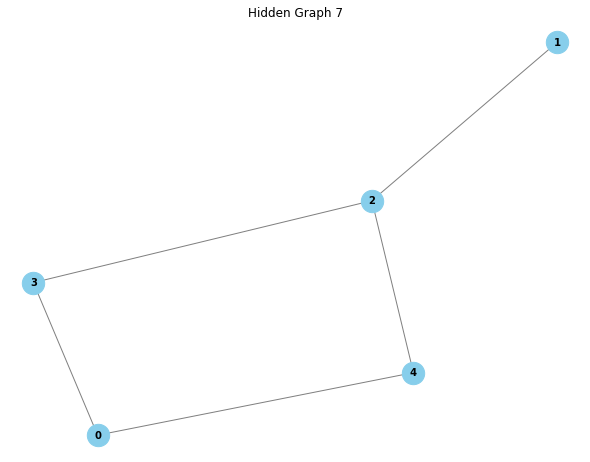

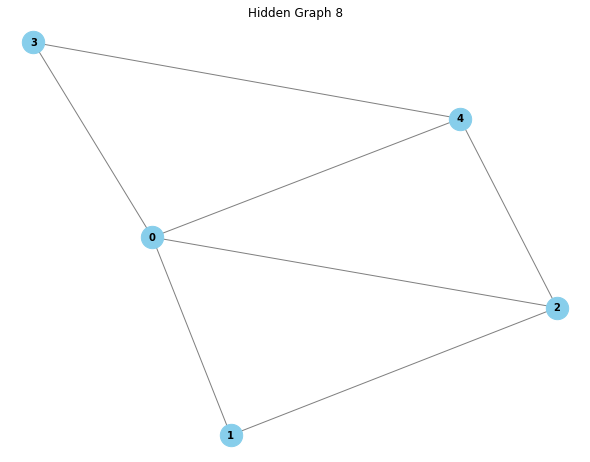

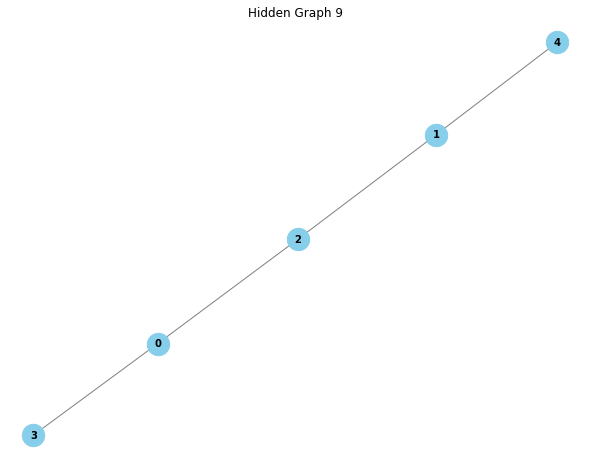

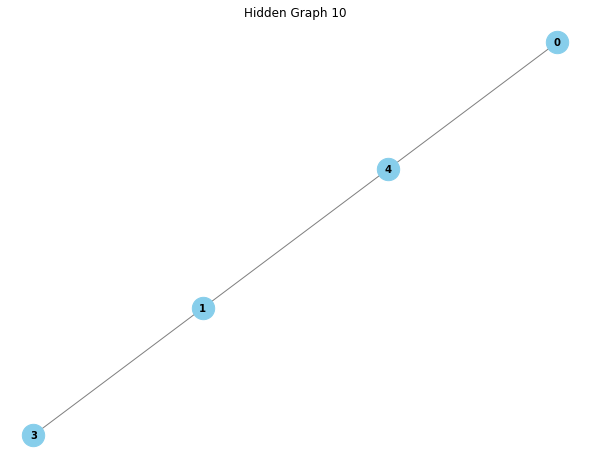

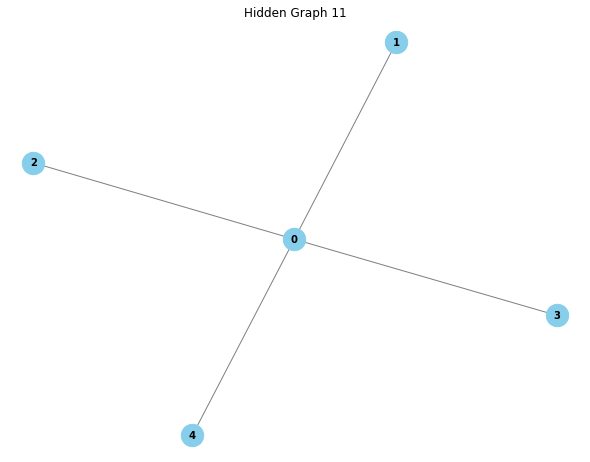

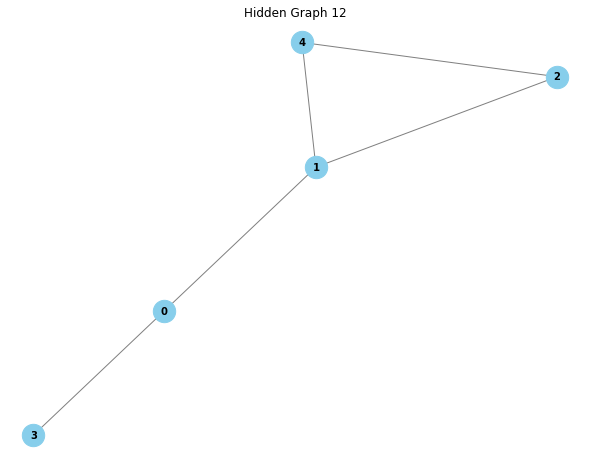

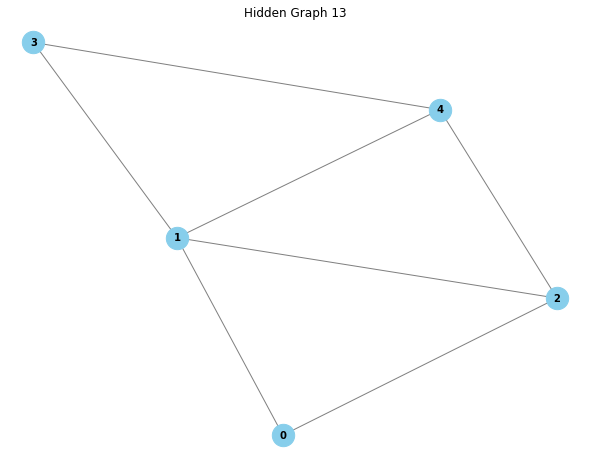

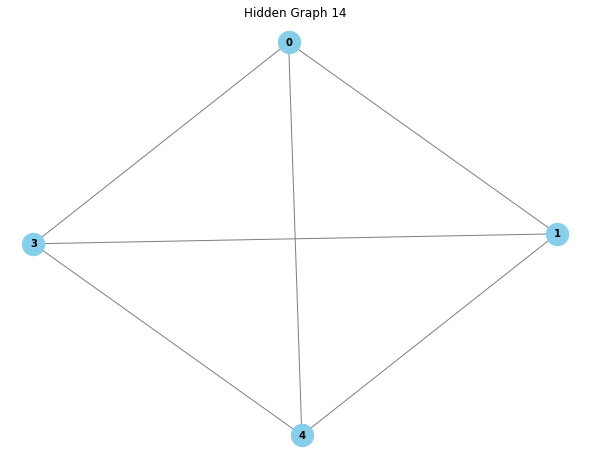

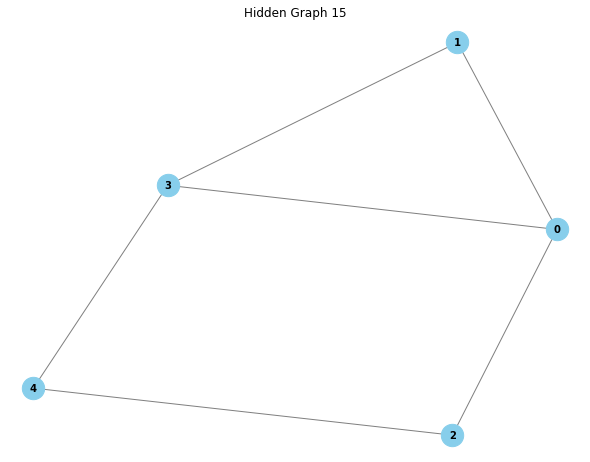

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming model is defined and adjacency lists are obtained as follows:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Hidden Graph {i}")
    plt.show()
